In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler

import torch
import torch.nn as nn

# Synthetic non-linear data
np.random.seed(42)
X = np.linspace(-3, 3, 300).reshape(-1, 1)
y = np.sin(X).ravel() + 0.3*np.random.randn(300)

# Partial least squares regression (PLSR)

**PLSR**: Model the relationship between predictors X and response y
* Step 1: Feature preparation
* Step 2: Extracting latent variables that maximize covariance between predictors and responses.
* Step 3: Regressing the response on these latent variables (using least square approach).

**Linear PLSR** assumes linear relationship between predictors and responses.
* Latent variables as a linear combination of explanatory variables $LV = B*X$
* Regression model as a linear combination of the latent variables $Y = W*LV$ 

In [51]:
# ------- Linear PLS (to show it fails on nonlinear data) -----------
pls_linear = PLSRegression(n_components=1).fit(X, y)
y_pred_linear = pls_linear.predict(X).ravel()

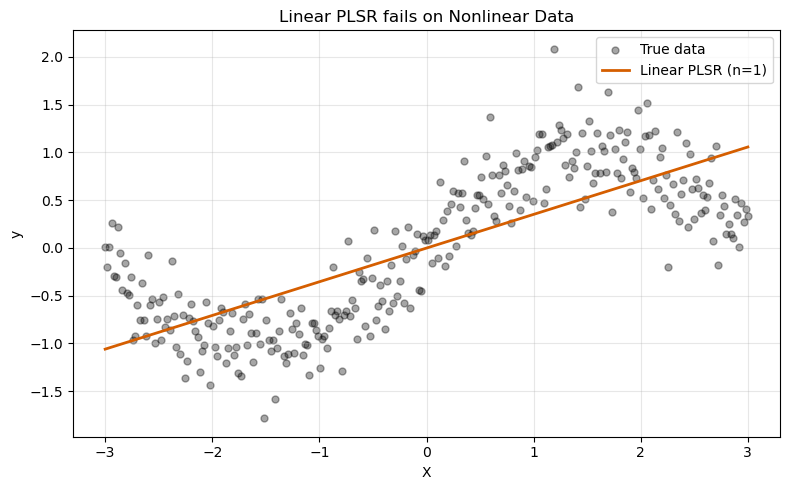

In [52]:
idx = np.argsort(X[:, 0]) # Sort X for a smooth line in the plot

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label="True data", alpha=0.35, color="black", s=25)
plt.plot(X[idx], y_pred_linear[idx], label="Linear PLSR (n=1)", color="#D55E00", linewidth=2.0)

plt.title("Linear PLSR fails on Nonlinear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Introducing non-linearity in PLSR (to model non-linear data)

**Step 1: Feature preparation: Modifing the feature space before deriving latent variables**
* Method 1: Augment the predictor matrix with polynomial terms
* Method 2: Use Kernel functions to map the original data into higer dimensional feature space

**Step 2: Extraction of latent variables**
* Unchanged to maintain the strenghts of PLSR 

**Step 3: Derivation of regression model**
* Method 3: Local Weighted PLSR - Applies PLSR locally around each prediction point using a weighted neighborhood.
* Method 4: Use a NN to model the relationship between the latent variables and the responses
* Method 5: Use a spline function 


## Step 1: Modifing the feature space before deriving latent variables

### Method 1: Augment the predictor matrix with polynomial terms
* Explicit creation of new features by adding terms such as $x_1^2, x_2^2, x_1 x_2, ...$
* Not computationally effective 
* Easy to interpret
* 
Also called "non-linear PLSR via input transformation"

### Method 2: Use Kernel functions $K(x_i, x_j)$ ("Kernel PLSR")
* Implicit projection of original data into higer-dimensional feature space using a kernel function
* Handles very complex nonlinear patterns without manually choosing polynomial degree.
* More computationaly eficient
* Harder to interpret

Note: The PLSR algorithm is adapted to work with the kernel matrix K, which replaces the original X. Therefore the higher-dimensional feature space is not explicitly constructed!

In [53]:
# --- Method 1: Polynomial feature expansion (explicit nonlinear features) ---
degree = 5 #  Degree of polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit PLS on polynomial features with various component counts. Number of components must be ≤ number of poly features.
pls_poly_1 = PLSRegression(n_components=1).fit(X_poly, y)
pls_poly_2 = PLSRegression(n_components=2).fit(X_poly, y)
pls_poly_5 = PLSRegression(n_components=5).fit(X_poly, y)

y_pred_poly_1 = pls_poly_1.predict(X_poly).ravel()
y_pred_poly_2 = pls_poly_2.predict(X_poly).ravel()
y_pred_poly_5 = pls_poly_5.predict(X_poly).ravel()

# --- Method 2: Kernel-style PLS via RBF random Fourier features + PLSR (implicit nonlinear features) ---
rbf = RBFSampler(gamma=0.5, n_components=100, random_state=42)  # gamma  = RBF width, n_components = Number of random Fourier features (higher can capture more detail, but heavier).
X_rbf = rbf.fit_transform(X)

pls_kernel = PLSRegression(n_components=5).fit(X_rbf, y)
y_pred_kernel = pls_kernel.predict(X_rbf).ravel()

# Comments:
# Kernel trick: Compute similarity between points in a transformed space without explicitly creating all features.
# We use RBF (Radial Basis Function) kernel approximation: Think of it as creating many “bumps” or localized features that can capture complex shapes.
# In our code: FSampler approximates the RBF kernel by generating random Fourier features. Then PLSR works in this transformed space

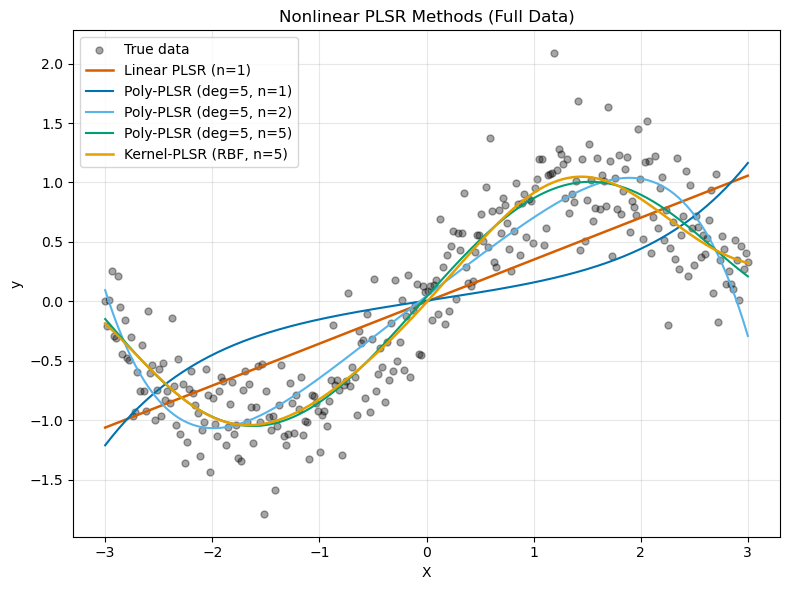

In [54]:
# Plot: data + linear baseline + nonlinear PLS curves
idx = np.argsort(X[:, 0])  # inline sort for smooth curves

plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="True data", alpha=0.35, color="black", s=25)

# Linear baseline (same as Section A)
plt.plot(X[idx], y_pred_linear[idx], label="Linear PLSR (n=1)", color="#D55E00", linewidth=1.8)

# Polynomial PLS curves
plt.plot(X[idx], y_pred_poly_1[idx], label=f"Poly-PLSR (deg={degree}, n=1)", color="#0072B2")
plt.plot(X[idx], y_pred_poly_2[idx], label=f"Poly-PLSR (deg={degree}, n=2)", color="#56B4E9")
plt.plot(X[idx], y_pred_poly_5[idx], label=f"Poly-PLSR (deg={degree}, n=5)", color="#009E73")

# Kernel PLS curve
plt.plot(X[idx], y_pred_kernel[idx], label="Kernel-PLSR (RBF, n=5)", color="#E69F00", linewidth=1.8)

plt.title("Nonlinear PLSR Methods (Full Data)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Step 3: Derivation of a non-linear regression model
### Method 3: Local Weighted PLSR

Another form of non-linear PLSR that will be adressed by another group :) 

In [ ]:
# Magnus' example

## Step 3: Derivation of a non-linear regression model

### Method 4: Use a NN to model the relationship between the latent variables and the responses
* Very flexible and powerful for modeling highly non-linear systems
* Requires careful training and regularization
* Interpretability is low

also called "NN-PLSR"

Are we still using least square approach in **NN-PLSR**? 
* YES but not always. NN can use a least squares loss function (MSE loss), combined with a gradient descent optimization method.


In [17]:
import torch
import torch.nn as nn

np.random.seed(42)
n_points=150
x = np.linspace(-3, 3, n_points).reshape(-1, 1)
y = np.sin(x).ravel() + 0.3*np.random.randn(n_points)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple neural network for regression
class RegressionNN(nn.Module):
    def __init__(self):
        nb_nodes = 8
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, 1)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model, define loss function and optimizer
model = RegressionNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

# Predict using the trained model
model.eval()
predicted = model(x_tensor).detach().numpy()

# Plot the original sine wave, noisy data, and model predictions
plt.figure(figsize=(10, 6))
# plt.plot(x, np.sin(x), label='Original Sine Wave', linestyle='--')
plt.scatter(x, y, label='Training Data', alpha=0.3, color='black')
plt.plot(x, predicted, label='NN-PLSR Prediction', color='green')
plt.legend()
plt.title('NN-PLSR on Noisy Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()



ModuleNotFoundError: No module named 'torch'

## Step 3: Derivation of a non-linear regression model

### Method 5: Use a spline function 
* Uses spline functions (e.g., B-splines) to model non-linear relationships between latent variables and response
* Requires knot selection and can be sensitive to overfitting
* Still has some level of interpretability

also called "Spline-based PLSR"

Are we still using least square approach in **Spline-based PLSR**? 
* YES! The regression coefficients are estimated by minimizing the squared error between predicted and actual responses.

In [ ]:
# Hilmi's example

# Non-linear PLSR - A summary

1. Introduce non-linearity in the feature space before deriving latent variables

   Method 1: Augment the **predictor matrix with polynomial terms**

   Method 2: Use Kernel functions to **map the original data into higer dimensional feature space**
   
3. Introduce non-linearity in derivation of regression model

   Method 3: Use a **spline function**

   Method 4: Use a **NN to model the relationship** between the latent variables and the responses


Comment: This are some options, but more methods can be applied


In [63]:
#Hilmi insert flow-chart as summary (or intro)

## References

PLSR
* https://www.youtube.com/watch?v=Vf7doatc2rA
* https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html 

Non-linear PLSR
* Rosipal, Roman. "Nonlinear partial least squares an overview." Chemoinformatics and advanced machine learning perspectives: complex computational methods and collaborative techniques (2011): 169-189. https://www.researchgate.net/publication/266488967_Nonlinear_Partial_Least_Squares_An_Overview